# prepare PL data

In [1]:
# helpers
import requests
import getpass



def get_token(url, name=None, password=None):
    user = name if name is not None else input("Username")
    print("Passwort: \n")
    # password = getpass.getpass()
    
    # Get a token from the api, login
    response = requests.get(
        f'{url}/auth/token', params=dict(username=user, password=password))    
    return response.json()['access_token']

def get_entryid(url, token, sample_id):  # give it a batch id
    # get al entries related to this batch id
    query = {
        'required': {
            'metadata': '*'
        },
        'owner': 'visible',
        'query': {'results.eln.lab_ids': sample_id},
        'pagination': {
            'page_size': 100
        }
    }
    response = requests.post(
        f'{url}/entries/query', headers={'Authorization': f'Bearer {token}'}, json=query)
    data = response.json()["data"]
    assert len(data) == 1
    return data[0]["entry_id"]


def get_specific_data_of_sample(url, token, sample_id, entry_type, with_meta=False):
    # collect the results of the sample, in this case it are all the annealing temperatures
    entry_id = get_entryid(url, token, sample_id)
    
    query = {
        'required': {
            'metadata': '*',
            'data': '*',
        },
        'owner': 'visible',
        'query': {'entry_references.target_entry_id': entry_id},
        'pagination': {
            'page_size': 100
        }
    }
    response = requests.post(f'{url}/entries/archive/query',
                             headers={'Authorization': f'Bearer {token}'}, json=query)
    linked_data = response.json()["data"]
    res = []
    for ldata in linked_data:
        # if entry_type == "":
        #     res.append(ldata["archive"]["data"])
        #     continue
        if entry_type not in ldata["archive"]["metadata"]["entry_type"]:
            continue
        if with_meta:
            res.append((ldata["archive"]["data"],ldata["archive"]["metadata"]))
        else:
            res.append(ldata["archive"]["data"])
    return res 

In [2]:
import toml
with open("./api_config.toml") as f:
    config = toml.load(f)
    pwd = config["nomad_api"]["password"]

In [3]:
%%capture
%matplotlib widget
# !pip install lmfit

import itertools
import pandas as pd
# from helpers import *
# from analysis import *
import matplotlib.pyplot as plt
import os
url = "http://localhost:8000/fairdi/nomad/latest/api/v1"
# url = "https://nomad-hzb-se.de/nomad-oasis/api/v1"
token = get_token(url, "wangyaru@physik.hu-berlin.de", pwd)
print(token)
# token = os.environ['NOMAD_CLIENT_ACCESS_TOKEN']
# print(token)

In [4]:
# library_id = "HZB_FaAk_20240321_4025-10"
# library_id = "HZB_FaAk_20240521_3928-14"
library_id = "HZB_FaAk_20240522_4030-02"
# library_id ="FAI_TeTe_20240524_4025-12"
# library_id = "HZB_FaAk_20240522_4030-02"
data = get_specific_data_of_sample(url, token, library_id, "")

In [195]:
# import json
# with open('data.json', 'w') as f:
#     json.dump(data, f)

In [2]:
import json
with open('data.json', 'r') as f:
    data = json.load(f)

In [3]:
for d in data:
    print(d.get("m_def"))
# grid = [(m["position_x"],m["position_y"]) for m in data[2].get("measurements")]

hzb_combinatorial_libraries.schema.UnoldTRPLMeasurementLibrary
hzb_combinatorial_libraries.schema.UnoldPLMeasurementLibrary
hzb_combinatorial_libraries.schema.UnoldThermalEvaporation
hzb_combinatorial_libraries.schema.UnoldUVvisTransmissionMeasurementLibrary
hzb_combinatorial_libraries.schema.UnoldUVvisReflectionMeasurementLibrary
hzb_combinatorial_libraries.schema.UnoldXRFMeasurementLibrary
hzb_combinatorial_libraries.schema.UnoldConductivityMeasurementLibrary


In [4]:
count = 0
for d in data:
    if count == 2:
        break
    if d.get("m_def") == "hzb_combinatorial_libraries.schema.UnoldPLMeasurementLibrary":
        pl_data = d
        count += 1
    if d.get("m_def") == "hzb_combinatorial_libraries.schema.UnoldConductivityMeasurementLibrary":
        conductivity_data = d
        count += 1
    if d.get("m_def") == "hzb_combinatorial_libraries.schema.UnoldXRFMeasurementLibrary":
        xrf_data = d
        count += 1

In [5]:
# for d in data_local:
#     if d.get("m_def") == "hzb_combinatorial_libraries.schema.UnoldXRFMeasurementLibrary":
#         xrf_data = d

In [6]:
lab_id = pl_data["samples"][0]["lab_id"]
lab_id

'HZB_FaAk_20240522_4030-02'

In [7]:
wavenumber = pl_data["wavelength"]

In [8]:
import numpy as np
measurements = pl_data["measurements"]
for measurement in measurements:
    measurement["data"] = np.array(measurement["data"]["intensity"])
    

In [9]:
import pandas as pd

pl_df = pd.DataFrame(pl_data["measurements"])

In [10]:
pl_df

,name,position_x,position_y,position_z,data
0,"2.0,3.0,5.0",2.0,3.0,5.0,"[-0.007, 0.001, 0.001, 0.011, 0.0, 0.007, -0.0..."
1,"4.0,3.0,5.0",4.0,3.0,5.0,"[0.002, 0.003, 0.012, -0.001, 0.007, -0.001, 0..."
2,"6.0,3.0,5.0",6.0,3.0,5.0,"[0.003, 0.001, 0.011, -0.001, 0.008, 0.0, -0.0..."
3,"8.0,3.0,5.0",8.0,3.0,5.0,"[0.003, 0.0, 0.011, -0.001, 0.009, -0.001, -0...."
4,"10.0,3.0,5.0",10.0,3.0,5.0,"[0.0, 0.001, 0.011, -0.003, 0.009, -0.001, -0...."
...,...,...,...,...,...
524,"38.0,47.0,5.0",38.0,47.0,5.0,"[0.001, 0.002, 0.013, -0.001, 0.011, -0.0, -0...."
525,"40.0,47.0,5.0",40.0,47.0,5.0,"[-0.01, 0.001, 0.002, 0.012, -0.0, 0.013, 0.00..."
526,"42.0,47.0,5.0",42.0,47.0,5.0,"[0.003, 0.004, 0.012, 0.001, 0.011, 0.001, -0...."
527,"44.0,47.0,5.0",44.0,47.0,5.0,"[0.003, -0.001, 0.012, -0.004, 0.009, -0.001, ..."


# plot uv-vis

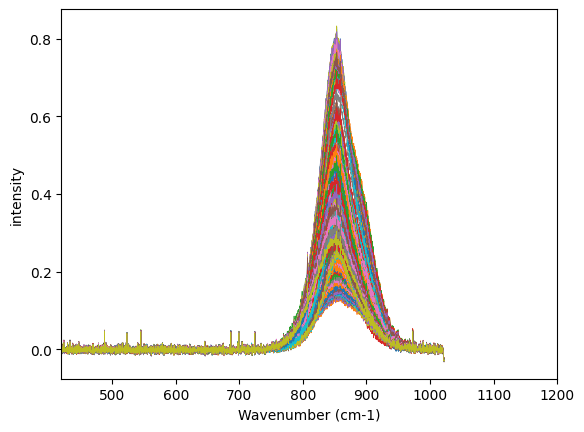

In [11]:
from matplotlib import pyplot as plt
fig, ax=plt.subplots()
for i in range(len(pl_df)):
    uv_data = pl_df.at[i, 'data']
    ax.plot(wavenumber, uv_data, linewidth=0.5)
    ax.set_xlim([min(wavenumber), 1200])
    ax.set_xlabel('Wavenumber (cm-1)')
    ax.set_ylabel('intensity')

# get PL integral

In [12]:
wavenumber = np.array(wavenumber)
for i in range(len(pl_df)):
    uv_data = pl_df.at[i, 'data']
    fit_range_mask = (wavenumber >= 700.0) & (wavenumber <= 980.0) # change range according to pl spectra
    x_range = wavenumber[fit_range_mask]
    y_range = uv_data[fit_range_mask]
    area = np.trapz(y_range, x_range)
    pl_df.at[i, 'integral_pl'] = area

In [13]:
pl_df

,name,position_x,position_y,position_z,data,integral_pl
0,"2.0,3.0,5.0",2.0,3.0,5.0,"[-0.007, 0.001, 0.001, 0.011, 0.0, 0.007, -0.0...",29.298883
1,"4.0,3.0,5.0",4.0,3.0,5.0,"[0.002, 0.003, 0.012, -0.001, 0.007, -0.001, 0...",25.069257
2,"6.0,3.0,5.0",6.0,3.0,5.0,"[0.003, 0.001, 0.011, -0.001, 0.008, 0.0, -0.0...",23.936573
3,"8.0,3.0,5.0",8.0,3.0,5.0,"[0.003, 0.0, 0.011, -0.001, 0.009, -0.001, -0....",23.599292
4,"10.0,3.0,5.0",10.0,3.0,5.0,"[0.0, 0.001, 0.011, -0.003, 0.009, -0.001, -0....",22.684202
...,...,...,...,...,...,...
524,"38.0,47.0,5.0",38.0,47.0,5.0,"[0.001, 0.002, 0.013, -0.001, 0.011, -0.0, -0....",31.027444
525,"40.0,47.0,5.0",40.0,47.0,5.0,"[-0.01, 0.001, 0.002, 0.012, -0.0, 0.013, 0.00...",29.112278
526,"42.0,47.0,5.0",42.0,47.0,5.0,"[0.003, 0.004, 0.012, 0.001, 0.011, 0.001, -0....",27.291256
527,"44.0,47.0,5.0",44.0,47.0,5.0,"[0.003, -0.001, 0.012, -0.004, 0.009, -0.001, ...",25.413730


# add energy scale

In [14]:
#variables
h = 6.62607004e-34     # m^2 kg s^-1    , planck constant
c = 2.99792458e8       # m s^-1         , speed of light
q = 1.6021766208e-19   # joule          , eV to joule
hc = 1239.84198        # eV nm          , planck constant times speed of light in eV


#laser_flux = 5.42e21   # photons m^-2 s^-1
kt_at_RT = 25.7        # meV



In [15]:
energy=hc/np.array(wavenumber)

In [16]:
# jocobian transformation
# intensity_energy_scale = hc * y / energy**2
pl_df['energy_data'] = pl_df['data'].apply(lambda data: hc * data / energy**2)

In [17]:
pl_df

,name,position_x,position_y,position_z,data,integral_pl,energy_data
0,"2.0,3.0,5.0",2.0,3.0,5.0,"[-0.007, 0.001, 0.001, 0.011, 0.0, 0.007, -0.0...",29.298883,"[-0.9962212839967188, 0.14246474872451484, 0.1..."
1,"4.0,3.0,5.0",4.0,3.0,5.0,"[0.002, 0.003, 0.012, -0.001, 0.007, -0.001, 0...",25.069257,"[0.2846346525704911, 0.42739424617354455, 1.71..."
2,"6.0,3.0,5.0",6.0,3.0,5.0,"[0.003, 0.001, 0.011, -0.001, 0.008, 0.0, -0.0...",23.936573,"[0.4269519788557366, 0.14246474872451484, 1.56..."
3,"8.0,3.0,5.0",8.0,3.0,5.0,"[0.003, 0.0, 0.011, -0.001, 0.009, -0.001, -0....",23.599292,"[0.4269519788557366, 0.0, 1.5687348244194768, ..."
4,"10.0,3.0,5.0",10.0,3.0,5.0,"[0.0, 0.001, 0.011, -0.003, 0.009, -0.001, -0....",22.684202,"[0.0, 0.14246474872451484, 1.5687348244194768,..."
...,...,...,...,...,...,...,...
524,"38.0,47.0,5.0",38.0,47.0,5.0,"[0.001, 0.002, 0.013, -0.001, 0.011, -0.0, -0....",31.027444,"[0.14231732628524554, 0.2849294974490297, 1.85..."
525,"40.0,47.0,5.0",40.0,47.0,5.0,"[-0.01, 0.001, 0.002, 0.012, -0.0, 0.013, 0.00...",29.112278,"[-1.4231732628524554, 0.14246474872451484, 0.2..."
526,"42.0,47.0,5.0",42.0,47.0,5.0,"[0.003, 0.004, 0.012, 0.001, 0.011, 0.001, -0....",27.291256,"[0.4269519788557366, 0.5698589948980594, 1.711..."
527,"44.0,47.0,5.0",44.0,47.0,5.0,"[0.003, -0.001, 0.012, -0.004, 0.009, -0.001, ...",25.413730,"[0.4269519788557366, -0.14246474872451484, 1.7..."


# peak_pos, FWHM

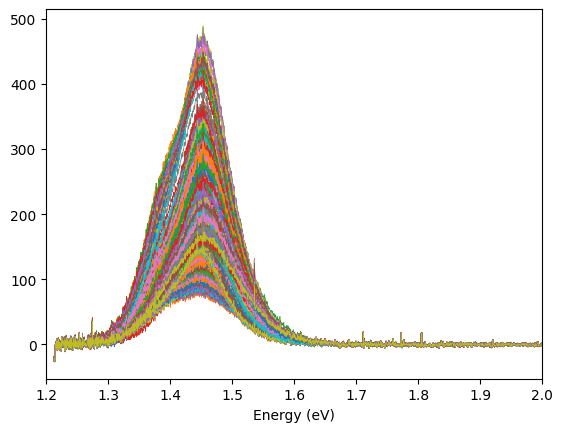

In [18]:
fig, ax=plt.subplots()
for i in range(len(pl_df)):
    energy_data = pl_df.at[i, 'energy_data']
    ax.plot(energy, energy_data, linewidth=0.5)
    ax.set_xlim([1.2, 2])
    ax.set_xlabel('Energy (eV)')

## fit gaussian

In [19]:
# to visualize measured data, to check for anormalities.
## to check & visiaulize gaussian fit
# todo why the peak is not the real peak as shown in the plot ?

# Define the Gaussian function
from scipy.optimize import curve_fit
def gaussian(x, amp, mean, stddev):
    return amp * np.exp(-((x - mean) / (2 * stddev))**2)

# Function to fit Gaussian and plot
def plotRTA(spectra_number, fit_gaussian=True):
    # Extract x and y data
    x_data = energy
    y_data = pl_df.at[spectra_number, 'energy_data']

 
    uv_data = pl_df.at[i, 'energy_data']
    ax.plot(x_data, uv_data, linewidth=0.5)
        # ax.set_xlim([min(wavenumber), 1200]) 

    
    # Plotfit_gaussian original data
    plt.plot(x_data, y_data, label="Original Data")
    plt.axvline(x=1.47 ,color="red",linestyle=':', linewidth=2, label="Peak=1.47 eV")
    # Fit Gaussian if requested
    if fit_gaussian:
        # Restricting fit range between 1.2 and 1.5 eV
        fit_range_mask = (x_data >= 1.2) & (x_data <= 1.75)
        x_fit = x_data[fit_range_mask]
        y_fit = y_data[fit_range_mask]
        
        try:
            popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=[100, 1.45, 1])

            y_fit = gaussian(x_fit, *popt)
        
            plt.plot(x_fit, y_fit, label="Gaussian Fit")
        except RuntimeError:
            print("Error - curve_fit failed.")
            
    
    
    # Set plot parameters
    plt.xlabel("PL Energy (eV)") 
    plt.ylabel("Intensity")
    plt.xlim(1,3)
    #plt.ylim(-0.025,0.2)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=20, title_fontsize=18)
    plt.grid(True)
    
    plt.show()

# Create interactive plot
from ipywidgets import interactive
interactive_plot = interactive(plotRTA, spectra_number=(2, len(pl_df)-1), fit_gaussian=True)
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot    

interactive(children=(IntSlider(value=265, description='spectra_number', max=528, min=2), Checkbox(value=True,…

## Find peak

In [20]:
#Gaussian fit for PL
#change range for different bandgaps

class PL_funcs:
    def __init__(self, data):
        self.data = data
    
    @staticmethod
    def gaussian(xg, amp, mean, stddev):
        return amp * np.exp(-((xg - mean) / (2 * stddev))**2)
    
    def fit_gaussian(self, x_data, y_data):
        # Restricting fit range between 1.2 and 1.5 eV
        fit_range_mask = (x_data >= 1.2) & (x_data <= 1.75)
        x_fit = x_data[fit_range_mask]
        y_fit = y_data[fit_range_mask]
        
        try:
            popt, pcov = curve_fit(self.gaussian, x_fit, y_fit, p0=[100, 1.45, 1])
            return popt
        except RuntimeError:
            return None

    def find_peak(self, x_data, y_data):
        popt = self.fit_gaussian(x_data, y_data)
        if popt is not None:
            peak_pos = popt[1]  # mean of the Gaussian is the peak position
            return peak_pos
        else:
            return None

In [21]:
from scipy.optimize import curve_fit
pl_analyzer = PL_funcs(pl_df)

columns = []
peak_positions = []

x_data = energy
for i in range(len(pl_df)):
    y_data = pl_df.at[i, 'energy_data']
    # to find peak position
    popt = pl_analyzer.fit_gaussian(x_data, y_data)
       
 
    if popt is not None:
        A_fit, mu_fit, sigma_fit = popt # which should be used for max peak ? # a_fit hight, nu_fit mean, sigma_fit std deviation
        FWHM_fit = 2 * np.sqrt(2 * np.log(2)) * sigma_fit
        pl_df.at[i, 'peak_pos'] = mu_fit
        pl_df.at[i, 'FWHM'] = FWHM_fit
    else:
        print(f"Error - curve_fit failed for row {i}.")
        pl_df.at[i, 'peak_pos'] = np.nan
        pl_df.at[i, 'FWHM'] = np.nan        

In [22]:
pl_df

,name,position_x,position_y,position_z,data,integral_pl,energy_data,peak_pos,FWHM
0,"2.0,3.0,5.0",2.0,3.0,5.0,"[-0.007, 0.001, 0.001, 0.011, 0.0, 0.007, -0.0...",29.298883,"[-0.9962212839967188, 0.14246474872451484, 0.1...",1.458661,0.090822
1,"4.0,3.0,5.0",4.0,3.0,5.0,"[0.002, 0.003, 0.012, -0.001, 0.007, -0.001, 0...",25.069257,"[0.2846346525704911, 0.42739424617354455, 1.71...",1.458552,-0.097590
2,"6.0,3.0,5.0",6.0,3.0,5.0,"[0.003, 0.001, 0.011, -0.001, 0.008, 0.0, -0.0...",23.936573,"[0.4269519788557366, 0.14246474872451484, 1.56...",1.457216,0.098129
3,"8.0,3.0,5.0",8.0,3.0,5.0,"[0.003, 0.0, 0.011, -0.001, 0.009, -0.001, -0....",23.599292,"[0.4269519788557366, 0.0, 1.5687348244194768, ...",1.455628,-0.099273
4,"10.0,3.0,5.0",10.0,3.0,5.0,"[0.0, 0.001, 0.011, -0.003, 0.009, -0.001, -0....",22.684202,"[0.0, 0.14246474872451484, 1.5687348244194768,...",1.455534,0.098601
...,...,...,...,...,...,...,...,...,...
524,"38.0,47.0,5.0",38.0,47.0,5.0,"[0.001, 0.002, 0.013, -0.001, 0.011, -0.0, -0....",31.027444,"[0.14231732628524554, 0.2849294974490297, 1.85...",1.455212,-0.092241
525,"40.0,47.0,5.0",40.0,47.0,5.0,"[-0.01, 0.001, 0.002, 0.012, -0.0, 0.013, 0.00...",29.112278,"[-1.4231732628524554, 0.14246474872451484, 0.2...",1.454807,-0.093783
526,"42.0,47.0,5.0",42.0,47.0,5.0,"[0.003, 0.004, 0.012, 0.001, 0.011, 0.001, -0....",27.291256,"[0.4269519788557366, 0.5698589948980594, 1.711...",1.455223,0.095625
527,"44.0,47.0,5.0",44.0,47.0,5.0,"[0.003, -0.001, 0.012, -0.004, 0.009, -0.001, ...",25.413730,"[0.4269519788557366, -0.14246474872451484, 1.7...",1.454959,0.096975


# Voc


In [23]:
# check ln or log ?
import math
pl_df['voc'] = pl_df.apply(lambda row: 0.932 * row['peak_pos'] + kt_at_RT * math.log(row['integral_pl']) - 0.0167 if row['integral_pl'] > 0 else float('nan'), axis=1)

In [24]:
pl_df

,name,position_x,position_y,position_z,data,integral_pl,energy_data,peak_pos,FWHM,voc
0,"2.0,3.0,5.0",2.0,3.0,5.0,"[-0.007, 0.001, 0.001, 0.011, 0.0, 0.007, -0.0...",29.298883,"[-0.9962212839967188, 0.14246474872451484, 0.1...",1.458661,0.090822,88.145792
1,"4.0,3.0,5.0",4.0,3.0,5.0,"[0.002, 0.003, 0.012, -0.001, 0.007, -0.001, 0...",25.069257,"[0.2846346525704911, 0.42739424617354455, 1.71...",1.458552,-0.097590,84.138877
2,"6.0,3.0,5.0",6.0,3.0,5.0,"[0.003, 0.001, 0.011, -0.001, 0.008, 0.0, -0.0...",23.936573,"[0.4269519788557366, 0.14246474872451484, 1.56...",1.457216,0.098129,82.949399
3,"8.0,3.0,5.0",8.0,3.0,5.0,"[0.003, 0.0, 0.011, -0.001, 0.009, -0.001, -0....",23.599292,"[0.4269519788557366, 0.0, 1.5687348244194768, ...",1.455628,-0.099273,82.583215
4,"10.0,3.0,5.0",10.0,3.0,5.0,"[0.0, 0.001, 0.011, -0.003, 0.009, -0.001, -0....",22.684202,"[0.0, 0.14246474872451484, 1.5687348244194768,...",1.455534,0.098601,81.566745
...,...,...,...,...,...,...,...,...,...,...
524,"38.0,47.0,5.0",38.0,47.0,5.0,"[0.001, 0.002, 0.013, -0.001, 0.011, -0.0, -0....",31.027444,"[0.14231732628524554, 0.2849294974490297, 1.85...",1.455212,-0.092241,89.615771
525,"40.0,47.0,5.0",40.0,47.0,5.0,"[-0.01, 0.001, 0.002, 0.012, -0.0, 0.013, 0.00...",29.112278,"[-1.4231732628524554, 0.14246474872451484, 0.2...",1.454807,-0.093783,87.977993
526,"42.0,47.0,5.0",42.0,47.0,5.0,"[0.003, 0.004, 0.012, 0.001, 0.011, 0.001, -0....",27.291256,"[0.4269519788557366, 0.5698589948980594, 1.711...",1.455223,0.095625,86.318324
527,"44.0,47.0,5.0",44.0,47.0,5.0,"[0.003, -0.001, 0.012, -0.004, 0.009, -0.001, ...",25.413730,"[0.4269519788557366, -0.14246474872451484, 1.7...",1.454959,0.096975,84.486264


# Bilinear Interpolation

In [25]:
x_pl = np.array(pl_df['position_x'])
y_pl = np.array(pl_df['position_y'])[::-1]
# z = pl_df['position_z']
pl_peak = np.array(pl_df['peak_pos'])

peak_data = pd.DataFrame({
    'x': x_pl,
    'y': y_pl,
    'pl_peak': pl_peak
})

In [26]:
peak_data

,x,y,pl_peak
0,2.0,47.0,1.458661
1,4.0,47.0,1.458552
2,6.0,47.0,1.457216
3,8.0,47.0,1.455628
4,10.0,47.0,1.455534
...,...,...,...
524,38.0,3.0,1.455212
525,40.0,3.0,1.454807
526,42.0,3.0,1.455223
527,44.0,3.0,1.454959


In [27]:
#Plotting coordinates and PL peak, PLQY
#here, coordinates are reversed in PLQY and PL.
#%matplotlib notebook

def plot_data(x_coords, y_coords, pl_peak_x, y_label, s_size):  
    fig, ax= plt.subplots(figsize=(8, 6))
    
    # todo why x_coords need to reverse, y_coords does not need to ?
    
    Q1 = np.nanpercentile(pl_peak_x, 10)
    Q2 = np.nanpercentile(pl_peak_x, 90)
    # print(pl_peak_x.dtype)
    
    scatter=ax.scatter(x_coords,y_coords, c=pl_peak_x, marker='o', cmap='viridis', s=s_size, vmin=Q1, vmax=Q2)
    cbar = plt.colorbar(scatter, ax=ax)
    #cbar.set_label('PLQY', fontsize=16)
    cbar.set_label(y_label, fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    plt.xticks(rotation=45)
   
    plt.show()
    #fig.savefig(r'D:\CsSnIBr0.3\PLmaps\4025-14\4025-14-PL_peak.png', dpi=500, bbox_inches='tight', transparent="True", pad_inches=0)

# plot_data() ##use peak_positions_df or integral_pl to visualize pl peak & plqy


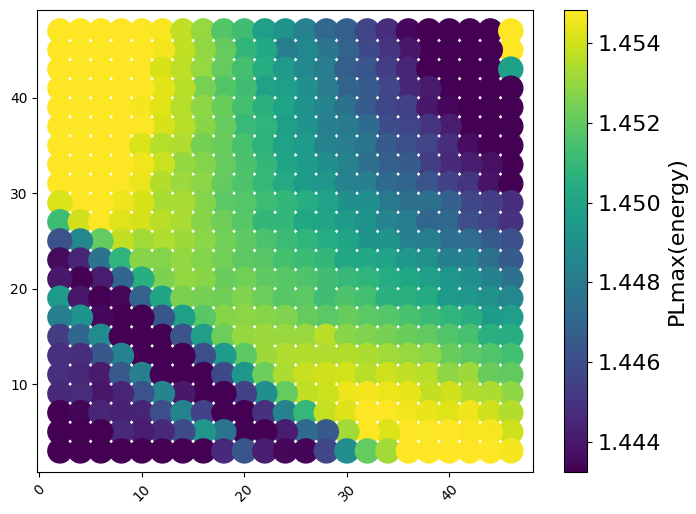

In [28]:
plot_data(peak_data['x'], peak_data['y'], peak_data['pl_peak'], 'PLmax(energy)', 300)

In [29]:
def bilinear_interpolation(x, y, value, x_new, y_new):

    """
    Perform bilinear interpolation to estimate the value at (x_new, y_new)
    within the grid defined by the points (x, y) and corresponding values.

    Args:
    - x: List of x-coordinates in ascending order.
    - y: List of y-coordinates in descending order.
    - values (list): List of corresponding values.
    - x_new (float): New x-coordinate for interpolation.
    - y_new (float): New y-coordinate for interpolation.

    Returns:
    - float: Interpolated value at (x_new, y_new).
    """
    # Find the indices of the points surrounding the target point
    i = 0

    while x[i] < x_new:
       
        i += 1
        if i == len(x) - 1:
            break

    j = 0
    while y[j] > y_new:
        j += 1
        if j == len(y) - 1:
            break

    x0, x1 = x[i - 1], x[i]
    y0, y1 = y[j - 1], y[j]
    

    """
    
    (x0, y0)   (x1, y0)
     (Q11)----(Q21)
       |       |
       |    Q  |
       |       |
    (Q12)----(Q22)
    (x0, y1)   (x1, y1)


    Q (x_new, y_new)
    """
    
    data = pd.DataFrame({
        'x': x,
        'y': y,
        'value': value,
    })
    
    Q12 = data.loc[(data['x'] == x0) & (data['y'] == y1)]["value"].values[0]
    Q11 = data.loc[(data['x'] == x0) & (data['y'] == y0)]["value"].values[0]
    Q21 = data.loc[(data['x'] == x1) & (data['y'] == y0)]["value"].values[0]
    Q22 = data.loc[(data['x'] == x1) & (data['y'] == y1)]["value"].values[0]


    x_factor = (x1 - x_new) / (x1 - x0)
    y_factor = (y1 - y_new) / (y1 - y0)

    interpolated_value = Q11 * x_factor * y_factor + Q21 * (1 - x_factor) * y_factor + \
                         Q12 * x_factor * (1 - y_factor) + Q22 * (1 - x_factor) * (1 - y_factor)

    return interpolated_value


# Bilinear interpolation evaluation

## generate more data

In [30]:
x_new = []
y_new = []
pl_peak_new = []

for i in range(0, 40, 1):
    for j in range(0, 40, 1):
        x_new.append(i)
        y_new.append(j)
        interpolated_value = bilinear_interpolation(x_pl, y_pl, np.array(peak_data["pl_peak"]), i, j)
        pl_peak_new.append(interpolated_value)
        # print(x, y, interpolated_value)
        
# plot_data(np.array(x_new), np.array(y_new), np.array(pl_peak_new), 30)

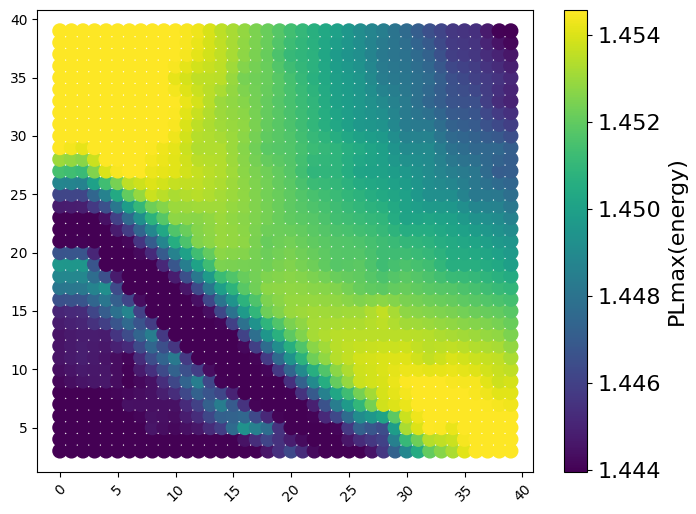

In [31]:
plot_data(np.array(x_new), np.array(y_new), np.array(pl_peak_new), 'PLmax(energy)', 100)

# get xrf data

In [32]:
def get_elements_from_str(ele_str):
    elements = []
    ele_strs =  ele_str.split('[%]')
    for s in ele_strs[:-1]:
        ele = s.split(':')[1].strip()
        elements.append(ele)
    return elements

In [33]:
elements = get_elements_from_str(xrf_data['material_names'])
print(elements)

['Si', 'Cs', 'Sn', 'I', 'Br']


In [34]:
measurement = xrf_data['measurements'][0]
for k, v in measurement.items():
        print(k)

name
position_x
position_y
data_file
layer


In [35]:
layer1_data = []
for measurement in xrf_data["measurements"]:
    layer1 = measurement['layer'][1]    
    amt = []
    for comp in layer1['composition']:
        amt.append(comp["amount"])
        # todo check len(amt) == len(elements)
        layer_dict = {
        "thickness": layer1['thickness'],
        "amount": amt,
        }
       
        layer1_data.append(layer_dict)

In [36]:
for l in layer1_data:
    if len(l.get("amount")) != 4:
        print(len(l.get("amount")))

# Conductivity

In [37]:
for d in data:
    if d.get("m_def") == "hzb_combinatorial_libraries.schema.UnoldConductivityMeasurementLibrary":
        conductivity_data = d

In [46]:
conductivities = []
conductivity_measurements = conductivity_data["measurements"]
for measurement in conductivity_measurements:
    conductivities.append(measurement)

conductivity_df = pd.DataFrame(conductivities)

{'name': '4.0,3.0,2.0', 'position_x': 4.0, 'position_y': 3.0, 'position_z': 2.0, 'conductivity': 1022370.0000000001}


In [39]:
conductivity_df

,name,position_x,position_y,position_z,conductivity
0,"4.0,3.0,2.0",4.0,3.0,2.0,1022370.0
1,"6.0,3.0,2.0",6.0,3.0,2.0,993701.0
2,"8.0,3.0,2.0",8.0,3.0,2.0,974605.0
3,"10.0,3.0,2.0",10.0,3.0,2.0,1016190.0
4,"12.0,3.0,2.0",12.0,3.0,2.0,1008830.0
...,...,...,...,...,...
479,"12.0,45.0,2.0",12.0,45.0,2.0,382063.0
480,"10.0,45.0,2.0",10.0,45.0,2.0,367545.0
481,"8.0,45.0,2.0",8.0,45.0,2.0,331513.0
482,"6.0,45.0,2.0",6.0,45.0,2.0,299846.0


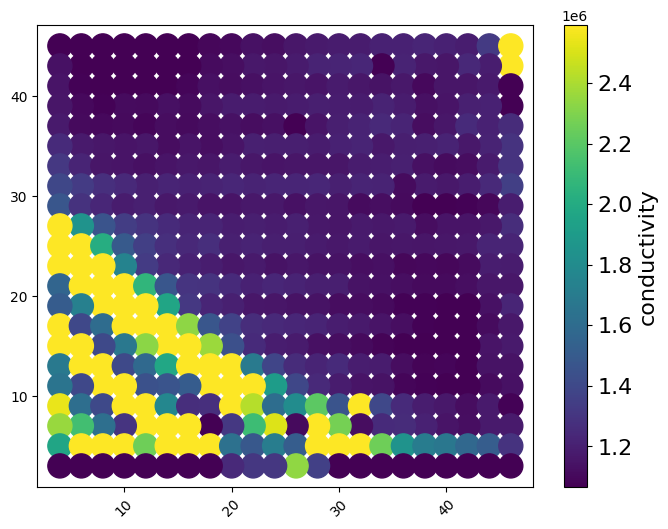

In [40]:
x_conductivity = np.array(conductivity_df['position_x'])
y_conductivity = np.array(conductivity_df['position_y'])[::-1]
conductivity = np.array(conductivity_df['conductivity']) # todo log scale
plot_data(x_conductivity, y_conductivity, conductivity, 'conductivity', 300)

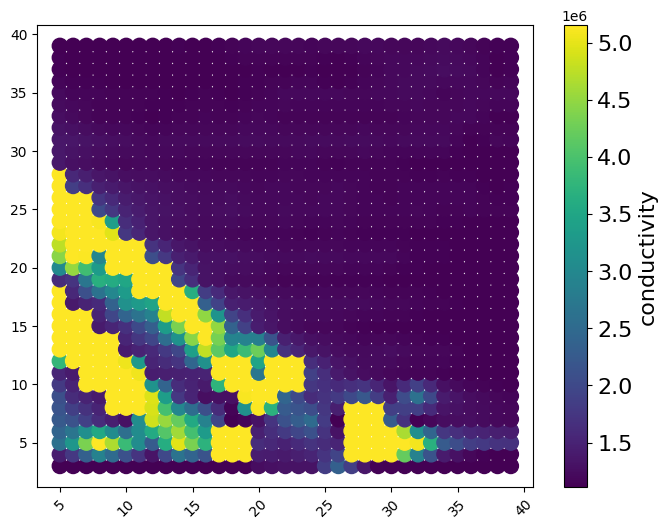

In [41]:
x_new = []
y_new = []
conductivity_new = []

for i in range(0, 40, 1):
    for j in range(0, 40, 1):
        x_new.append(i)
        y_new.append(j)
        interpolated_value = bilinear_interpolation(x_conductivity, y_conductivity, conductivity, i, j)
        conductivity_new.append(interpolated_value)
        # print(x, y, interpolated_value)

plot_data(np.array(x_new), np.array(y_new), np.array(conductivity_new), 'conductivity', 120)

# create Pixels

In [42]:
# def get_molecular_formula(compound, concentration_fraction):
#     """
#     get_molecular_formula returns the molecular formula of a compound given its composition and molecular concentration fraction.
#     for example: compounds= ["Sn2O4", "Cu2O"], xrf_concentration = [2.699, 97.3], returns "(SnO2)2.6999(Cu2O)97.3"
#     """
#     if len(compound) != len(concentration_fraction):
#         raise ValueError("compounds and concentration_fraction must have the same length")
#     molecular_formula = ""
#     for i in range(len(compound)):
#         molecular_formula += f"({compound[i]}){concentration_fraction[i]}"
#     return molecular_formula

In [45]:
from nomad.datamodel import EntryArchive
from nomad.datamodel import EntryMetadata
from hzb_combinatorial_libraries.schema import Pixel
from hzb_combinatorial_libraries.schema import PixelProperty
from nomad_material_processing.combinatorial import CombinatorialSamplePosition
from nomad.datamodel.metainfo.basesections import (
    EntityReference,
    Collection,
    PubChemPureSubstanceSection,
    CompositeSystemReference,
    Measurement,
    PureSubstanceComponent,
    ElementalComposition,
)
from nomad.units import ureg

import json
import zipfile
import os

lab_id = "HZB_FaAk_20240522_4030-02"
pixel_files = []
for i in range(0, len(pl_df)):
    plqy = pl_df.loc[i, 'integral_pl']/100
    voc = pl_df.loc[i, 'voc']
    fwhm = pl_df.loc[i, 'FWHM']

    x = pl_df.loc[i, 'position_x']
    y = pl_df.loc[i, 'position_y']
   
    x_quantity = ureg.Quantity(x, 'millimeter').to('meter').magnitude # defaultDisplayUnit mm, but the unit for x and y is meter
    y_quantity = ureg.Quantity(y, 'millimeter').to('meter').magnitude

    con = bilinear_interpolation(x_conductivity, y_conductivity, conductivity, x, y)
    position = CombinatorialSamplePosition(x=x_quantity, y=y_quantity)
    
    thickness = ureg.Quantity(layer1_data[i]['thickness'], 'nanometer').to('centimeter').magnitude

    pixel_property = PixelProperty(thickness=thickness,PLQY=plqy, implied_voc=voc, FWHM=fwhm, conductivity=con)

    pixel = Pixel(properties=pixel_property)
    
    data = {}
    archive = EntryArchive(metadata=EntryMetadata())
    archive.data = pixel
    archive.data.position = position
    archive.data.lab_id = f"{lab_id}:Pixel-{i}" # add xy as labid        

    if len(layer1_data[i]['amount']) == len(elements)-1 or len(elements) != 5:
        for j in range(len(elements)-1):
            elemental_composition = ElementalComposition(
            element = elements[j+1],
            mass_fraction = layer1_data[i]['amount'][j]
            )
            
            archive.data.elemental_composition.append(elemental_composition)
        # normalize_all(archive)

    json_data = archive.m_to_dict()
    json_data['data']['m_def'] = "hzb_combinatorial_libraries.schema.Pixel" 

    import json
    # JSON(archive.m_to_dict())
    
    temp_filename = f'temp_{i}.archive.json'
    with open(temp_filename, 'w') as f:
        json.dump(json_data, f, indent=2)
    
    pixel_files.append(temp_filename)


    if i == 3:
        break

# import zipfile
# with zipfile.ZipFile("pixels.zip", 'w') as zipf:
#     # Loop through the list of files and add each one to the ZIP
#     for file in pixel_files:
#         zipf.write(file, arcname=file)
#         os.remove(file)